# CD4+ T cell behavior in COVID-19 infection


In [1]:
# Load library and BoolNetPerturb functions
library(dplyr)
library(BoolNet)
library(alluvial)
for (f in list.files("BNP")) { source( paste('BNP/', f, sep='') ) }
# Load data
net <-  loadNetwork("data/thsocs_net.csv")
env <- read.csv("data/thsocs_environment.csv")
lab <- read.csv("data/thsocs_label.csv")

net.socs <- c('SOCS1', 'SOCS2', 'SOCS3', 'SOCS5')
net.ext  <- c('IFNGe', 'IL12e', 'IL2e', 'IL4e', 'IL6e', 'TGFBe', 'IL10e', 'TCR')

net.covmod <- fixGenes(net, colnames(env), env['CoV-mod',])
net.covsev <- fixGenes(net, colnames(env), env['CoV-sev',])
net.covtgfb <- fixGenes(net, colnames(env), env['CoV-sev-TGFB',])


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## CD4+ T cell regulatory network and subsets

### Regulatory network
* nodes: 22       
* edges: 82       


In [2]:
print(c('# nodes :', length(net$genes)))
net.topo <- getNetTopology(net)
writexl::write_xlsx(net.topo,'results/thsocs_net_topology.xlsx')
print(c('# edges :', length(net.topo[[1]]) - sum(sapply(net$genes, isGeneInput, net=net))  ))

[1] "# nodes :" "21"       
[1] "# edges :" "81"       


### Attractors

* Naive
* Th0
* Th1
* Th2
* Th17
* Treg
* Tr - including TrIL4+
* Th1R - including Treg IFNG+ & IL4+ \cite{}
* Th2R
* Anergy

In [3]:
file.attr <- 'results/thsocs_attr_table.csv'
file.attr.fig <- "images/thsocs_attr_table.eps"

# calculate attractors
attr <- getAttractors(net, method="sat.exhaustive")
attr.table <- attractorToDataframe(attr, Boolean=TRUE)
# label by attractor
labels <- labelAttractors(attr, lab, net_$genes, simplify=F)
attr.table <- merge(x=attr.table, y=labels, by.x = 'attractor', by.y = 0)
colnames(attr.table)[colnames(attr.table) == "y"] <- "label"
attr.table$size <- stringr::str_count(attr.table$label,'/')+1
attr.table <- attr.table[c(c("label", "attractor", "state","size"),net$genes)]
# sort and save
write.csv(attr.table,file.attr, row.names=FALSE)
#tail(attr.table,10)
unique(labels)

[1] "Th17"   "Anergy" "Treg"   "Tr"     "Th2R"   "Th1R"   "Th2"    "Th1"   
[9] "Naive"

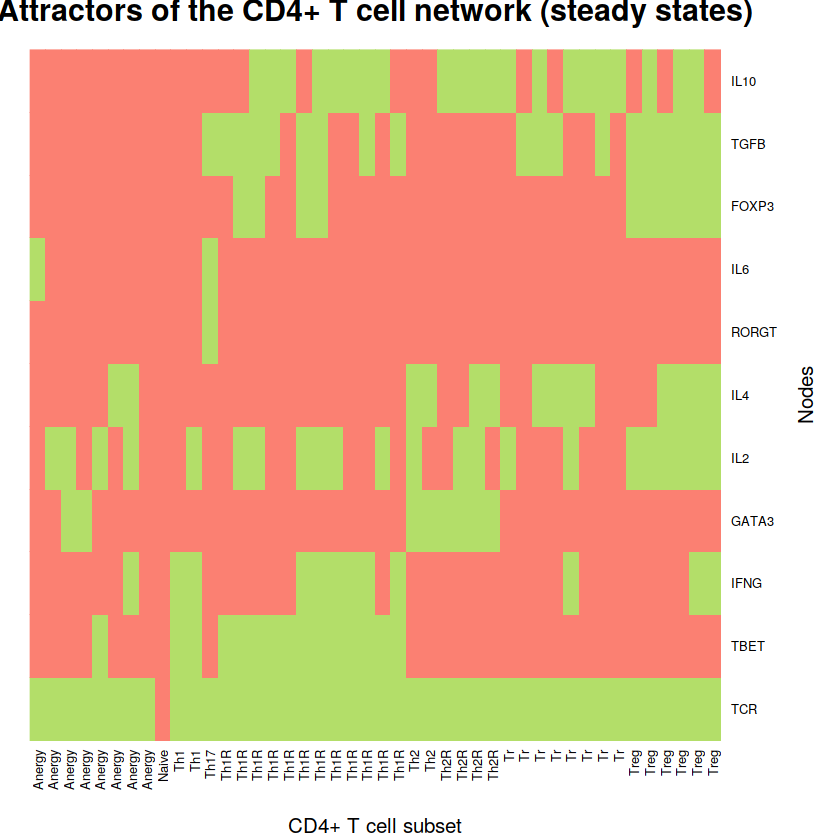

In [4]:
# select key nodes for plotting
attr.plot <- subset(attr.table, select = c("label", "attractor", "state", "size",
                                           "TCR", "TBET","IFNG","GATA3","IL2","IL4","RORGT","IL6","FOXP3","TGFB","IL10") )
attr.plot <- attr.plot[with(attr.table, order(label,attractor,state)),]

#setEPS(); postscript(file.attr.fig)
attr.plot.steady <- attr.plot[attr.plot$size==1,]
attr.plot.steady <- subset(attr.plot.steady, select=-c(attractor,state,size))
attr.plot.steady <- unique(attr.plot.steady)
heatmap(t(as.matrix( subset(attr.plot.steady, select=-label ))),
        labCol=attr.plot.steady$label,
        main="Attractors of the CD4+ T cell network (steady states)", 
        xlab="CD4+ T cell subset", ylab="Nodes",
        col=c('#fb8072','#b3de69'), cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
#dev.off()

#setEPS(); postscript(file.attr.fig)
attr.plot.cycle <- attr.plot[attr.plot$size>1,]
if (nrow(attr.plot.cycle)>0) {
heatmap(t(as.matrix( subset(attr.plot.cycle, select=-c(label,attractor,state,size) ))),
        labCol=attr.plot.cycle$label,
        main="Attractors of the CD4+ T cell network (cycles)", 
        xlab="CD4+ T cell subset", ylab="Nodes",
        col=c('#fb8072','#b3de69'), cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
    }
#dev.off()

In [5]:
# plot environments
env

,IFNGe,IL12e,IL2e,IL4e,IL6e,TGFBe,IL10e
Basal,0,0,0,0,0,0,0
pro-Th1,1,1,0,0,0,0,0
pro-Th2,0,0,1,1,0,0,0
pro-Th17,0,0,0,0,1,1,0
pro-Treg,0,0,1,0,0,1,0
Pro-Tr,0,0,0,0,0,1,1
CoV-mod,1,1,0,0,0,0,0
CoV-sev,1,1,0,1,1,0,0
CoV-sev-TGFB,1,1,0,1,1,1,0


### Basin size by environment

* CoV-mod has the same signature as Th1
* CoV-mod and CoV-sev have similar presence of celltypes:
    * Anergy, Th1, Th1R, Th2R, Tr
* In CoV-sev increase in anergy and Th1r, decreese in Th1, really high increase in Th0
    * Are we seeing anergy or cells that do not differentiate ever by signalling pathway competition
* If there is TGFB in CoV-sev we have Th17, Th1R and Tr with no Treg or Th1
    * possible worst outcome, activation of innate inflamation, no adaptive citotoxicity, also fibrosis
    * check TGFB in patients, while it may have regulatory effects it may induce 
    * role of microenvironment in pathology

,Basal,pro-Th1,pro-Th2,pro-Th17,pro-Treg,Pro-Tr,CoV-mod,CoV-sev,CoV-sev-TGFB
Anergy,50.9277344,7.5195312,4.8095703,0.000000,0.0000000,0.00000,7.5195312,32.1289062,0.00000
Th1,5.7373047,38.3300781,1.6601562,0.000000,0.0000000,0.00000,38.3300781,24.0234375,0.00000
Th17,0.0000000,0.0000000,0.0000000,53.125000,0.9521484,0.00000,0.0000000,0.0000000,21.09375
Th1R,12.7441406,48.7792969,1.6113281,6.640625,16.3085938,16.30859,48.7792969,38.9648438,62.98828
Th2,4.7607422,0.0000000,54.9560547,0.000000,0.0000000,0.00000,0.0000000,0.0000000,0.00000
Th2R,0.6835938,0.5371094,0.6835938,0.000000,0.0000000,0.00000,0.5371094,0.4882812,0.00000
Tr,25.1464844,4.8339844,7.2753906,40.234375,12.8784180,83.69141,4.8339844,4.3945312,15.91797
Treg,0.0000000,0.0000000,29.0039062,0.000000,69.8608398,0.00000,0.0000000,0.0000000,0.00000


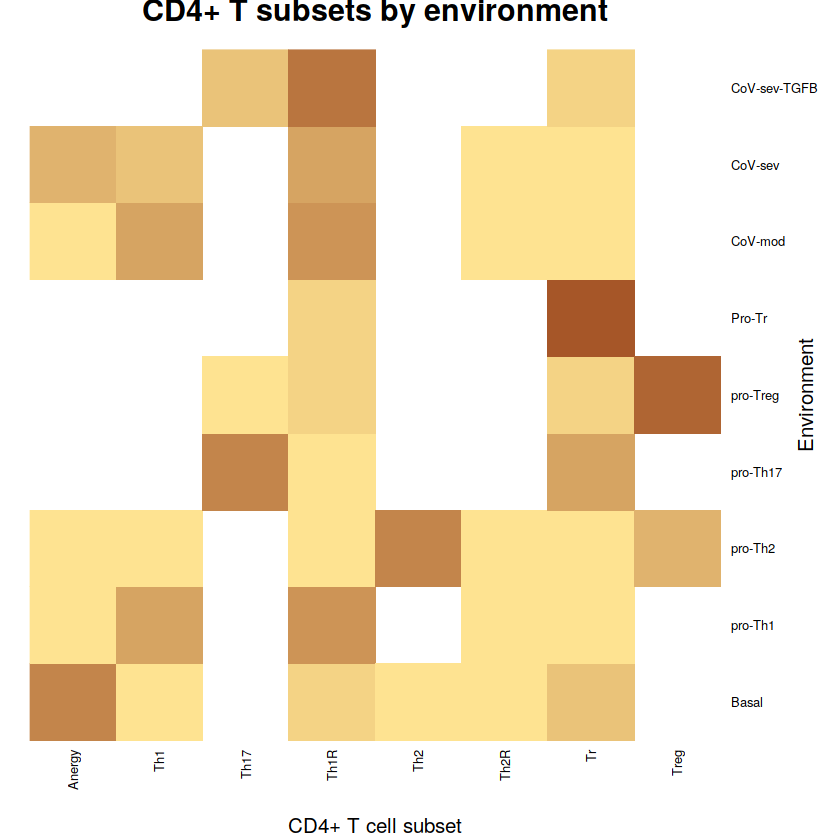

In [6]:
file.env.attr <- "results/thsocs_env_attr.csv"
file.env.attr.fig <- "images/thsocs_env_attr.eps"


env.attr <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize',
                                     genes  = rep( list(colnames(env)), times=nrow(env) ),
                                     values = lapply( split(env,seq_along(env[,1])), as.list),
                                     names  = rownames(env))
write.csv(env.attr,file.env.attr)
env.attr <- env.attr[row.names(env.attr) != "Naive", , drop = FALSE]
env.attr[] <- lapply( env.attr[], function(x) x/sum(x) )
env.attr  * 100

#setEPS(); postscript(file.env.attr.fig)
env.attr[env.attr == 0] <- NA
colfunc <- colorRampPalette(c('#fee391', '#a65628'))
color <- colfunc(10)
heatmap(t(as.matrix( subset(env.attr ))),
        main="CD4+ T subsets by environment", 
        xlab="CD4+ T cell subset", ylab="Environment",
        col=color, cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
#dev.off()

## CD4+ T cell stability and plasticity in COVID-19

In [7]:
f.cfm.table <- function(net, lab, file.name) {
    cfm <- cellFateMap(net, label.rules=lab, 
                       method="sat.restricted", maxAttractorLength=2) 
    cfm <- apply(cfm,2,as.character)
    cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
    write.csv(cfm,file.name, row.names=F)
    cfm <- read.csv(file.name)
    cfm
}

cfm.covmod <- f.cfm.table(net.covmod, lab, "results/thsocs_cfm_covmod.csv")
cfm.covsev <- f.cfm.table(net.covsev, lab, "results/thsocs_cfm_covsev.csv")
cfm.covtgfb <- f.cfm.table(net.covtgfb, lab, "results/thsocs_cfm_covtgfb.csv")

### Transitions by node

Key nodes: IFNG, IL10, TGFB (and TCR)

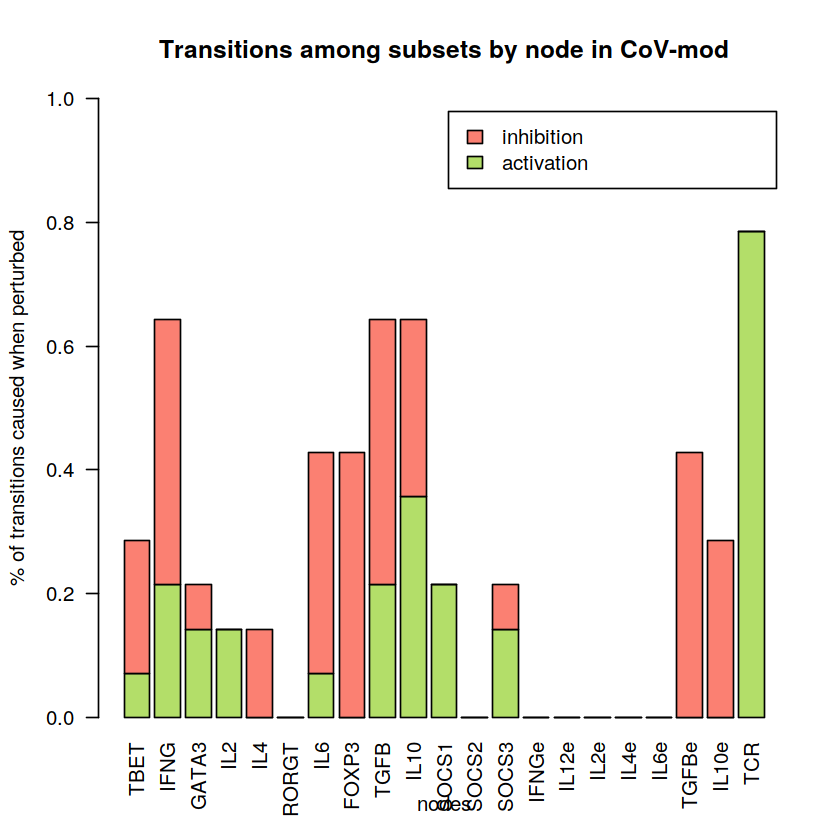

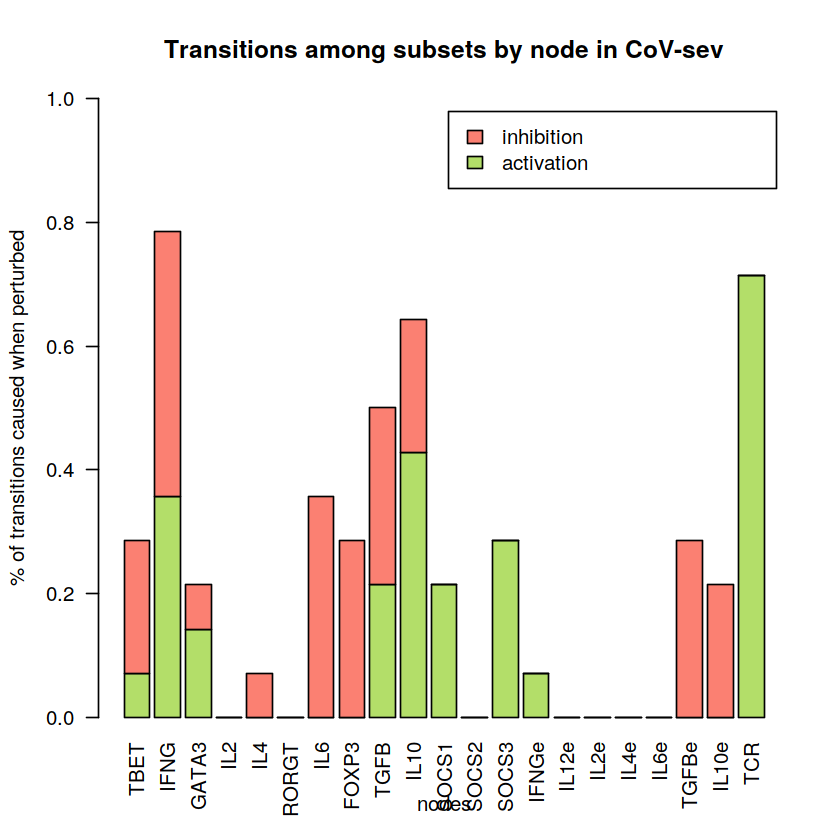

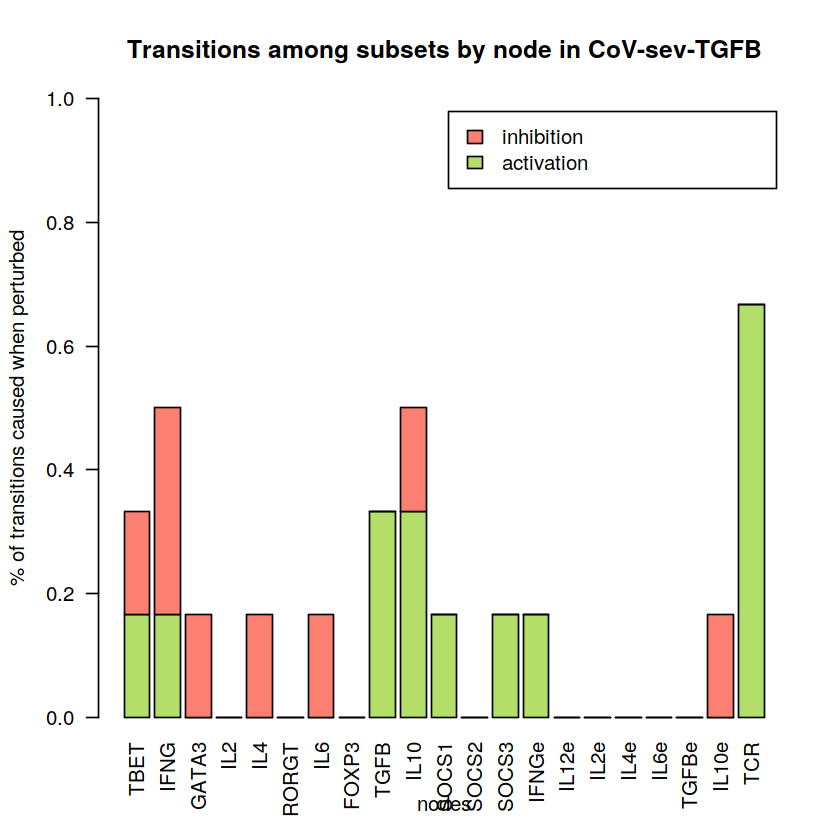

In [8]:
plot.node.transitions <- function(cfm, file.name='', normalize=T, title='') {
    cfm.diff <- cfm[cfm$initial!=cfm$final,]
    node.transitions <- merge( summary(cfm.diff[cfm.diff$values==0,'genes']), 
                               summary(cfm.diff[cfm.diff$values==1,'genes']),
                               by=0, all=TRUE)
    rownames(node.transitions) <- node.transitions$Row.names
    node.transitions <- subset(node.transitions, select = -Row.names )
    colnames(node.transitions) <- c('activation','inhibition')
    node.transitions <- node.transitions[net$genes,]
    if (normalize) { node.transitions <- node.transitions/summary(cfm$genes) }
    node.transitions
    
    #setEPS(); postscript(file.name)
    barplot(t(as.matrix( node.transitions )),
            main=title, xlab='nodes', ylab='% of transitions caused when perturbed',
            col=c('#b3de69','#fb8072'), ylim=c(0,1), las=2, legend=T,
           )
    #dev.off()
}

plot.node.transitions(cfm.covmod, 'images/thsocs_transitionnode_covmod.eps', 
                      title='Transitions among subsets by node in CoV-mod')
plot.node.transitions(cfm.covsev, 'images/thsocs_transitionnode_covsev.eps',
                      title='Transitions among subsets by node in CoV-sev')
plot.node.transitions(cfm.covtgfb, 'images/thsocs_transitionnode_covtgfb.eps',
                      title='Transitions among subsets by node in CoV-sev-TGFB')

### Stability by celltype

* CoV-mod, Th1 > Anergy both in basin size, stablity, and transitions towards
* CoV-sev, Th1 < Anergy both in basin size, stablity, and transitions towards
* Cov-TGFB, no anergy nor Th1, presence of Th17 and transitions towards
* Discuss roles of local microenvironment

[1] "Transitions between cell types in CoV-mod"


Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

[1] "Transitions between cell types in CoV-sev"


Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

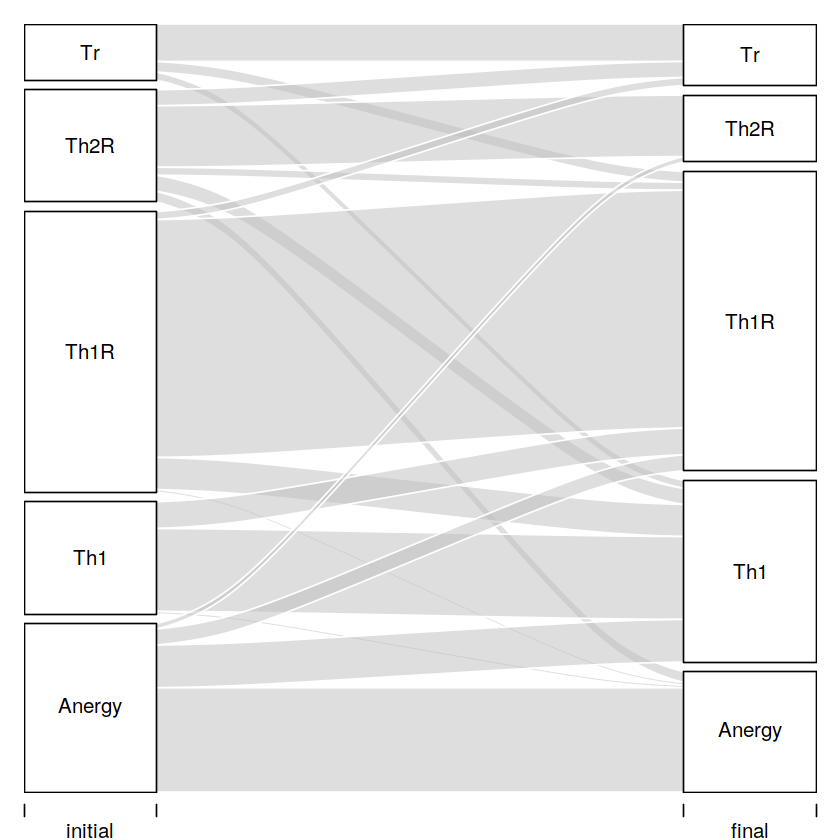

[1] "Transitions between cell types in CoV-sev-TGFB"


Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

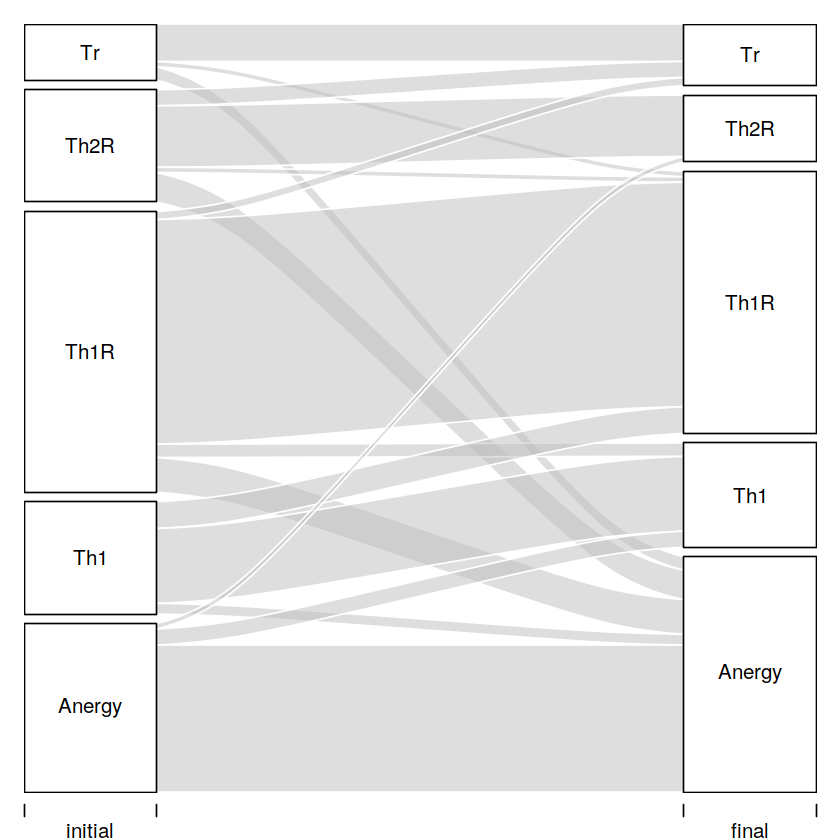

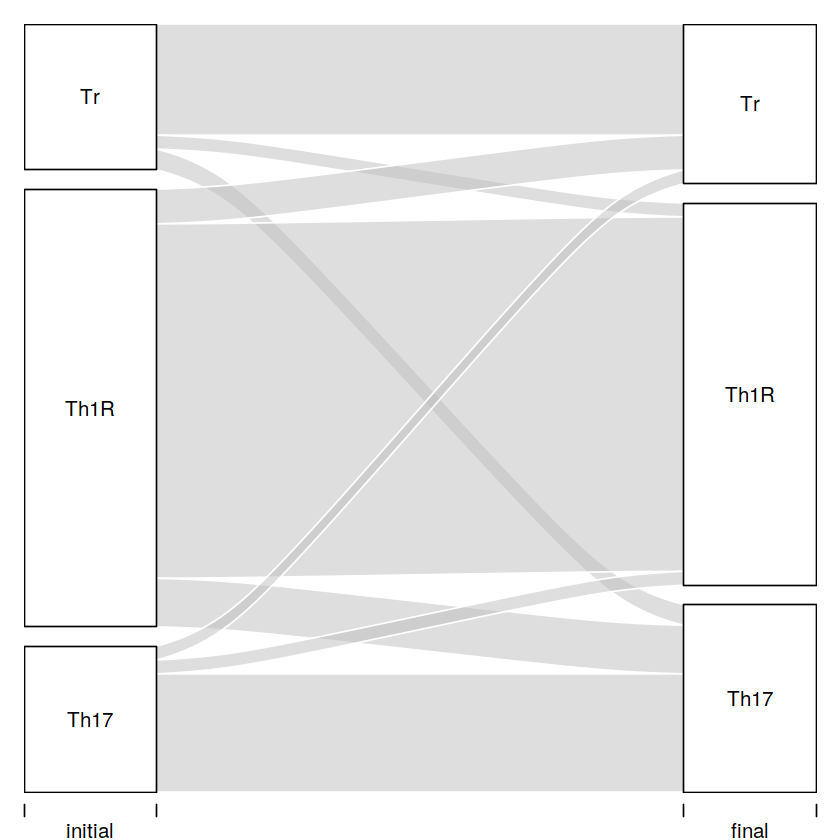

In [9]:
plot.cfm.alluvial <- function(cfm, file.name, title='', ignore='Naive') {
    #setEPS(); postscript(file.name)
    cfm <- cfm[cfm$initial!=ignore,]
    cfm2d <- cfm %>% group_by(initial, final) %>%
            summarize(freq = n())
    print(title)
    alluvial(cfm2d[,1:2], freq=cfm2d$freq)
    #dev.off()
    }

plot.cfm.alluvial(cfm.covmod, 'images/thsocs_alluvial_covmod.eps',
                  title='Transitions between cell types in CoV-mod')
plot.cfm.alluvial(cfm.covsev, 'images/thsocs_alluvial_covsev.eps',
                  title='Transitions between cell types in CoV-sev')
plot.cfm.alluvial(cfm.covtgfb, 'images/thsocs_alluvial_covtgfb.eps',
                  title='Transitions between cell types in CoV-sev-TGFB')

### Interventions and secondary effects
* IFNG_1: small effect, may activate some anergic->Th1, in CoV-TGFB may change Th17->Th1R
* IL21_1: no, secondary effects are strong inflamation/anergy
* IL10_0: no, some Th1R->Th1 but also induces anergy, in CoV-TGFB may change Th1R->Th17 
* TGFB_0: cautiously, good in CoV-Mod, small in CoV-Sev, may induce Th17 in CoV-TGFB so neccesary sustained treatment, see mutants to avoid CoV-TGFB, 
* SOCS_1: yes, increases Th1 with little secondary effects, see mutants, it increases Th1-basin, small effec in Th17-Th1R in CoV-TGFB
* SOCS_3: small effect, may induce anergy



In [10]:
cfm <- cfm.covmod
diff <- cfm[cfm$initial!=cfm$final,]
diff <- diff[diff$final=='Th1',]
print('Interventions')
diff
print('Secondary effects')
cfm[cfm$genes=='IFNG' & cfm$values==1,]
cfm[cfm$genes=='IL21' & cfm$values==1,]
cfm[cfm$genes=='IL10' & cfm$values==0,]
cfm[cfm$genes=='TGFB' & cfm$values==0,]
cfm[cfm$genes=='SOCS1' & cfm$values==0,]
cfm[cfm$genes=='SOCS3' & cfm$values==0,]


[1] "Interventions"


,initial,final,genes,values
40,Anergy,Th1,IFNG,1
41,Anergy,Th1,IFNG,1
42,Anergy,Th1,IFNG,1
43,Anergy,Th1,IL10,1
44,Anergy,Th1,IL10e,1
45,Anergy,Th1,IL2,0
46,Anergy,Th1,IL2,0
47,Anergy,Th1,IL4,1
48,Anergy,Th1,IL6,0
49,Anergy,Th1,SOCS1,0


[1] "Secondary effects"


,initial,final,genes,values
40,Anergy,Th1,IFNG,1
41,Anergy,Th1,IFNG,1
42,Anergy,Th1,IFNG,1
66,Naive,Naive,IFNG,1
151,Th1R,Th1R,IFNG,1
242,Th2R,Th1R,IFNG,1
243,Th2R,Th1R,IFNG,1
277,Tr,Th1R,IFNG,1


initial,final,genes,values


,initial,final,genes,values
129,Th1R,Th1,IL10,0
130,Th1R,Th1,IL10,0
157,Th1R,Th1R,IL10,0
158,Th1R,Th1R,IL10,0
233,Th2R,Anergy,IL10,0
237,Th2R,Th1,IL10,0
278,Tr,Th1R,IL10,0


,initial,final,genes,values
138,Th1R,Th1,TGFB,0
139,Th1R,Th1,TGFB,0
221,Th1R,Th1R,TGFB,0
276,Tr,Th1,TGFB,0


,initial,final,genes,values
49,Anergy,Th1,SOCS1,0
50,Anergy,Th1,SOCS1,0
51,Anergy,Th1,SOCS1,0
107,Th1,Th1,SOCS1,0
108,Th1,Th1,SOCS1,0
202,Th1R,Th1R,SOCS1,0
203,Th1R,Th1R,SOCS1,0
204,Th1R,Th1R,SOCS1,0
205,Th1R,Th1R,SOCS1,0
263,Th2R,Th2R,SOCS1,0


,initial,final,genes,values
111,Th1,Th1,SOCS3,0
112,Th1,Th1,SOCS3,0
212,Th1R,Th1R,SOCS3,0
213,Th1R,Th1R,SOCS3,0
214,Th1R,Th1R,SOCS3,0
215,Th1R,Th1R,SOCS3,0
216,Th1R,Th1R,SOCS3,0
244,Th2R,Th1R,SOCS3,0
267,Th2R,Th2R,SOCS3,0
279,Tr,Th1R,SOCS3,0


In [11]:
cfm <- cfm.covsev
diff <- cfm[cfm$initial!=cfm$final,]
diff <- diff[diff$final=='Th1',]
print('Interventions')
diff
print('Secondary effects')
cfm[cfm$genes=='IFNG' & cfm$values==1,]
cfm[cfm$genes=='IL21' & cfm$values==1,]
cfm[cfm$genes=='IL10' & cfm$values==0,]
cfm[cfm$genes=='TGFB' & cfm$values==0,]
cfm[cfm$genes=='SOCS1' & cfm$values==0,]
cfm[cfm$genes=='SOCS3' & cfm$values==0,]


[1] "Interventions"


,initial,final,genes,values
56,Anergy,Th1,IFNG,1
57,Anergy,Th1,IFNG,1
58,Anergy,Th1,IFNG,1
59,Anergy,Th1,SOCS1,0
60,Anergy,Th1,SOCS1,0
61,Anergy,Th1,SOCS1,0
140,Th1R,Th1,IL10,0
141,Th1R,Th1,IL10,0
142,Th1R,Th1,IL6,1
143,Th1R,Th1,SOCS3,0


[1] "Secondary effects"


,initial,final,genes,values
56,Anergy,Th1,IFNG,1
57,Anergy,Th1,IFNG,1
58,Anergy,Th1,IFNG,1
66,Naive,Naive,IFNG,1
155,Th1R,Th1R,IFNG,1
243,Th2R,Th1R,IFNG,1
244,Th2R,Th1R,IFNG,1
279,Tr,Th1R,IFNG,1


initial,final,genes,values


,initial,final,genes,values
131,Th1R,Anergy,IL10,0
140,Th1R,Th1,IL10,0
141,Th1R,Th1,IL10,0
160,Th1R,Th1R,IL10,0
234,Th2R,Anergy,IL10,0
235,Th2R,Anergy,IL10,0
274,Tr,Anergy,IL10,0


,initial,final,genes,values
139,Th1R,Anergy,TGFB,0
144,Th1R,Th1,TGFB,0
221,Th1R,Th1R,TGFB,0
278,Tr,Anergy,TGFB,0


,initial,final,genes,values
59,Anergy,Th1,SOCS1,0
60,Anergy,Th1,SOCS1,0
61,Anergy,Th1,SOCS1,0
78,Naive,Naive,SOCS1,0
109,Th1,Th1,SOCS1,0
110,Th1,Th1,SOCS1,0
204,Th1R,Th1R,SOCS1,0
205,Th1R,Th1R,SOCS1,0
206,Th1R,Th1R,SOCS1,0
207,Th1R,Th1R,SOCS1,0


,initial,final,genes,values
113,Th1,Th1,SOCS3,0
114,Th1,Th1,SOCS3,0
133,Th1R,Anergy,SOCS3,0
143,Th1R,Th1,SOCS3,0
214,Th1R,Th1R,SOCS3,0
215,Th1R,Th1R,SOCS3,0
216,Th1R,Th1R,SOCS3,0
238,Th2R,Anergy,SOCS3,0
267,Th2R,Th2R,SOCS3,0
276,Tr,Anergy,SOCS3,0


In [12]:
cfm <- cfm.covtgfb
diff <- cfm[cfm$initial!=cfm$final,]
diff <- diff[diff$final=='Th1',]
print('Interventions')
diff
print('Secondary effects')
cfm[cfm$genes=='IFNG' & cfm$values==1,]
cfm[cfm$genes=='IL21' & cfm$values==1,]
cfm[cfm$genes=='IL10' & cfm$values==0,]
cfm[cfm$genes=='TGFB' & cfm$values==0,]
cfm[cfm$genes=='SOCS1' & cfm$values==0,]
cfm[cfm$genes=='SOCS3' & cfm$values==0,]


[1] "Interventions"


initial,final,genes,values


[1] "Secondary effects"


,initial,final,genes,values
3,Naive,Naive,IFNG,1
39,Th17,Th1R,IFNG,1
56,Th1R,Th1R,IFNG,1
109,Tr,Th1R,IFNG,1


initial,final,genes,values


,initial,final,genes,values
45,Th1R,Th17,IL10,0
59,Th1R,Th1R,IL10,0
106,Tr,Th17,IL10,0


,initial,final,genes,values
37,Th17,Th17,TGFB,0
49,Th1R,Th17,TGFB,0
96,Th1R,Th1R,TGFB,0
97,Th1R,Th1R,TGFB,0
108,Tr,Th17,TGFB,0


,initial,final,genes,values
15,Naive,Naive,SOCS1,0
40,Th17,Th1R,SOCS1,0
86,Th1R,Th1R,SOCS1,0
87,Th1R,Th1R,SOCS1,0
88,Th1R,Th1R,SOCS1,0
123,Tr,Tr,SOCS1,0


,initial,final,genes,values
92,Th1R,Th1R,SOCS3,0
93,Th1R,Th1R,SOCS3,0
104,Th1R,Tr,SOCS3,0
125,Tr,Tr,SOCS3,0


## CD4+ T cell KO and overexpression mutants in COVID-19
    * [/] Mutants in WT, covmod, and covsev table
    * [/] Mutants in WT, covmod, and covsev scale:purple
    * [/] Compare covmod vs covsev

In [13]:
f.mut.table <- function(net, lab, file.name) {
    mutants <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize')
    mut_socs <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize',
                                         genes  = list(c('SOCS1','SOCS2','SOCS3'),c('SOCS1','SOCS2','SOCS3')),
                                         values = list(0,1),
                                         names  = c('SOCSall_0','SOCSall_1'))
    mutants <- merge(mutants, mut_socs, by=0, all=TRUE)
    rownames(mutants) <- mutants$Row.names
    mutants <- mutants[ , -which(names(mutants) %in% c("Row.names"))]
    mutants[mutants == 0] <- NA
    write.csv(mutants,file.name)
    mutants
}

f.mut.plot <- function(mutants, file.name, title='', normalize=T) {
    if (normalize) {
        mutants <- mutants/mutants
        color <- c('#bebada')
    } else {
        colfunc <- colorRampPalette(c('#bfd3e6', '#810f7c'))
        color <- colfunc(10)
    }
    #setEPS(); postscript(file.name)
    mutants
    heatmap(t(as.matrix( mutants )),
            main="CD4+ T subsets mutants", 
            xlab="CD4+ T cell subset", ylab="Mutant",
            col=color, cexCol=0.75, cexRow=0.75,
            Colv = NA, Rowv = NA, scale="none",
           )
    #dev.off()
}

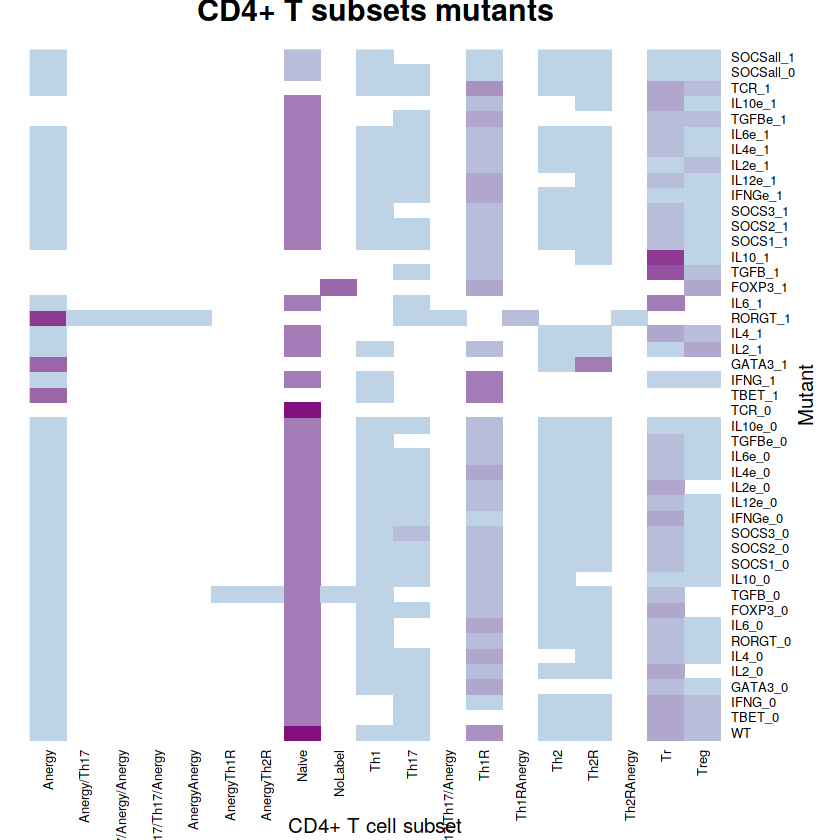

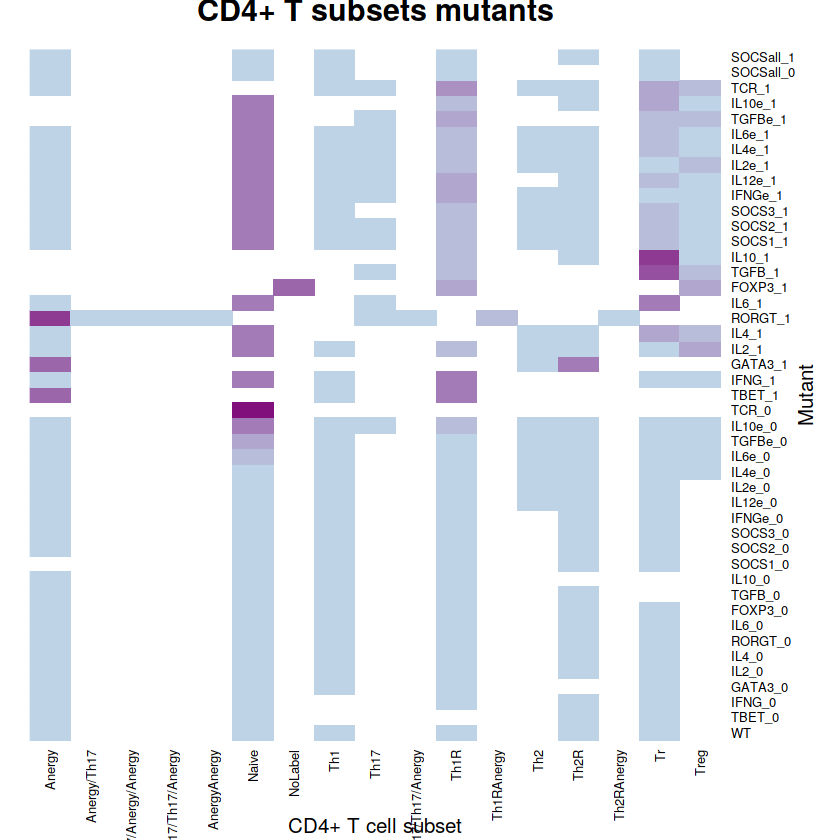

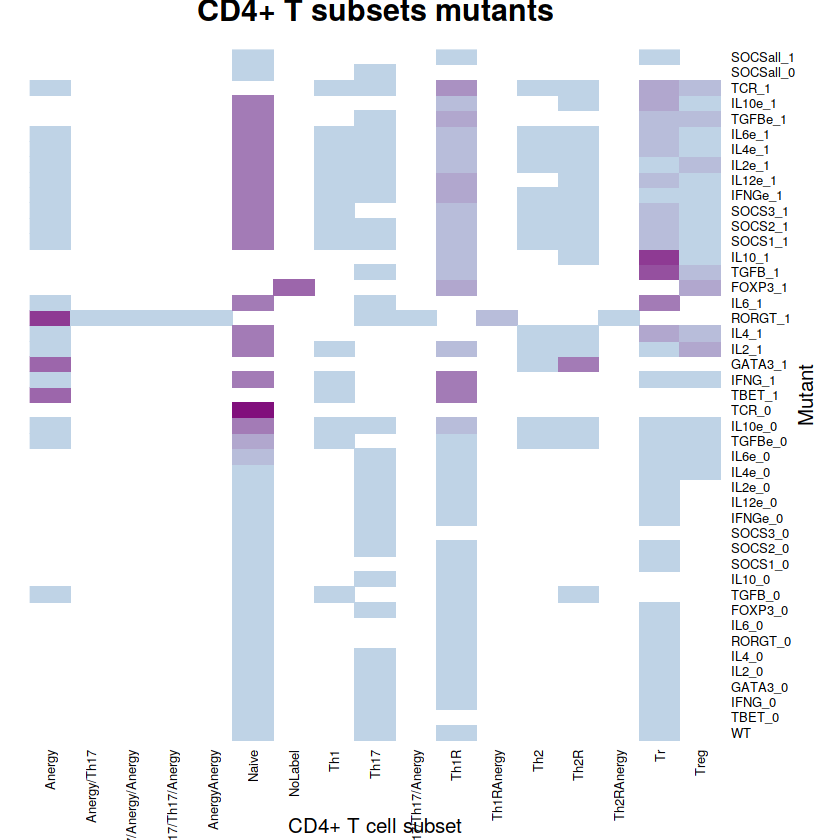

In [14]:
f.mut <- f.mut.table(net, lab, "results/thsocs_mut_wt.csv")
f.mut.plot(f.mut, "images/thsocs_mut_wt.eps", "CD4+ T subsets mutants", normalize=F)

f.mut.covmod <- f.mut.table(net.covmod, lab, "results/thsocs_mut_covmod.csv")
f.mut.plot(f.mut.covmod, "images/thsocs_mut_covmod.eps", "CD4+ T subsets mutants in CoV-mod", normalize=F)
           
f.mut.covsev <- f.mut.table(net.covsev, lab, "results/thsocs_mut_covsev.csv")
f.mut.plot(f.mut.covsev, "images/thsocs_mut_covsev.eps", "CD4+ T subsets mutants in CoV-sev", normalize=F)
           
f.mut.covtgfb <- f.mut.table(net.covtgfb, lab, "results/thsocs_mut_covtgfb.csv")
f.mut.plot(f.mut.covtgfb, "images/thsocs_mut_covtgfb.eps", "CD4+ T subsets mutants in CoV-sev + TGFBe", normalize=F)

### CoV-mod vs CoV-sev

Warning message in image.default(1L:nc, 1L:nr, x, xlim = 0.5 + c(0, nc), ylim = 0.5 + :
“unsorted 'breaks' will be sorted before use”

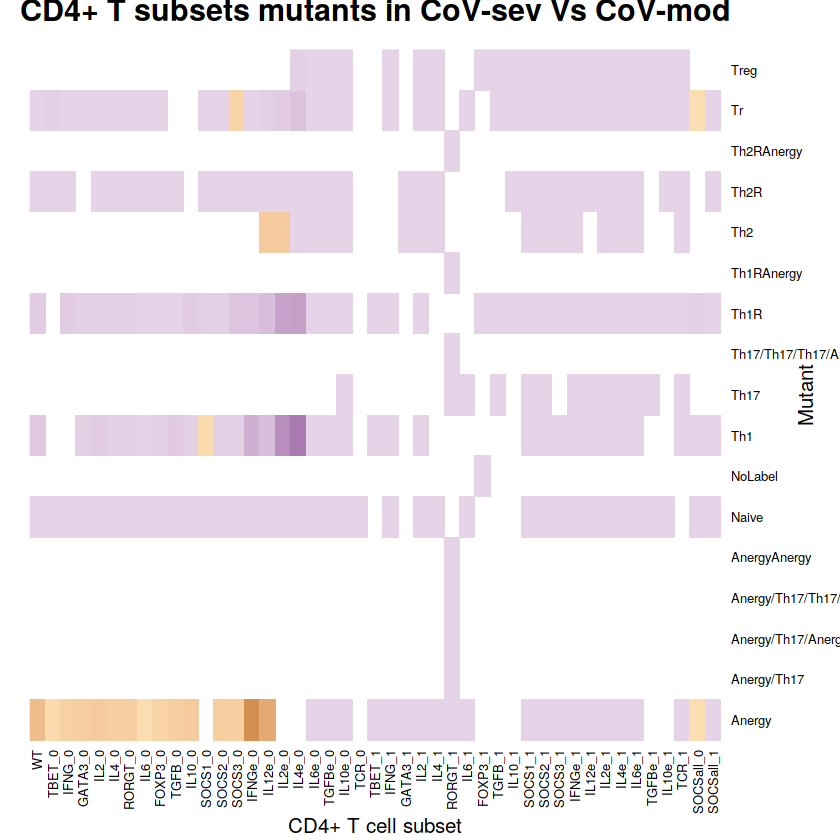

In [15]:
file.name <- 'images/thsocs_mut_covmodvssev.eps'

diff <- as.matrix(f.mut.covsev-f.mut.covmod)
Min <- -min(diff, na.rm = T)
Max <- -max(diff, na.rm = T)
Thresh <- 0

rc1 <- colorRampPalette(colors = c("#762a83", "#e7d4e8"), space="Lab")(50)    
rc2 <- colorRampPalette(colors = c("#fee0b6", "#b35806"), space="Lab")(50)
rampcols <- c(rc1, rc2)
rb1 <- seq(Min, Thresh, length.out=51)
rb2 <- seq(Thresh, Max, length.out=51)[-1]
rampbreaks <- c(rb1, rb2)

#setEPS(); postscript(file.name)
heatmap(diff, Rowv = NA, Colv = NA, scale="none",
        main="CD4+ T subsets mutants in CoV-sev Vs CoV-mod", 
        xlab="CD4+ T cell subset", ylab="Mutant",
        cexCol=0.75, cexRow=0.75,
        col = rampcols, breaks = rampbreaks)
#dev.off()

Done